### By: Bryan Aneyro Hernandez

## Imports

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import display, Image
from skimage import io

## Step 2: Upload and Display Image

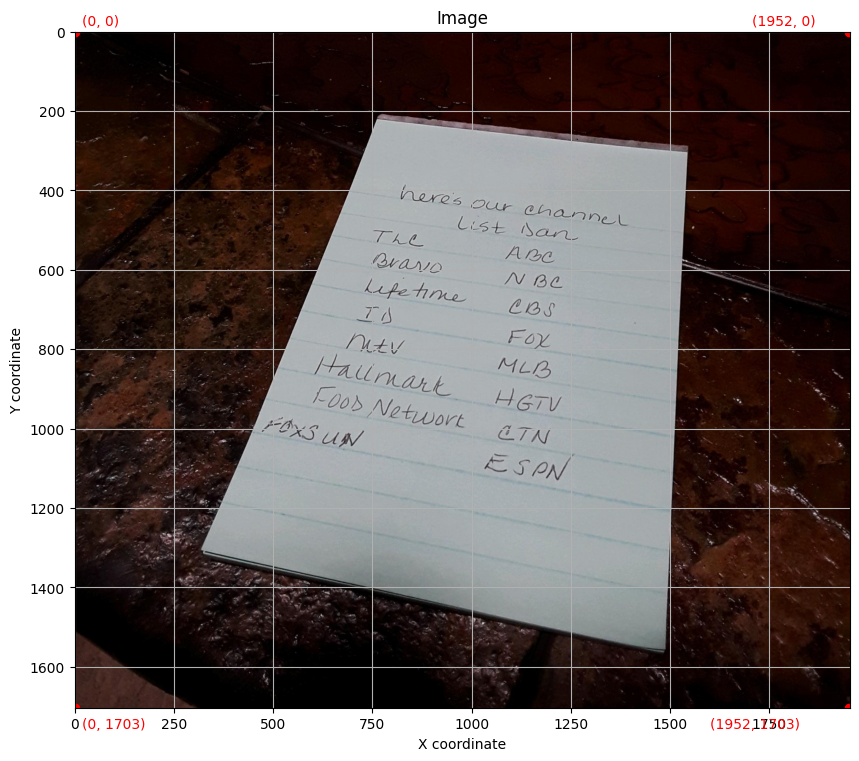

In [ ]:
import requests
def download_image(url):
    """
    Downloads an image from a direct URL and returns it in BGR format.
    """
    response = requests.get(url)
    if response.status_code != 200:
        raise ValueError(f"Request failed with status code {response.status_code}")
    image_data = np.frombuffer(response.content, np.uint8)
    image = cv2.imdecode(image_data, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError("Failed to decode image. Check if the URL points directly to an image file.")
    return image

# Replace the URL below with a direct image URL from Unsplash.
direct_url = "https://i.redd.it/bebi64i3kbb31.jpg"
image = download_image(direct_url)
# Convert from BGR to RGB for display in matplotlib
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def display_image_with_coords(image, title="Image"):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(title)
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.grid(True)

    # Get image dimensions (height, width, channels)
    height, width, _ = image.shape

    # Mark the four corners with red dots
    plt.plot(0, 0, 'ro')             # top-left
    plt.plot(width - 1, 0, 'ro')       # top-right
    plt.plot(0, height - 1, 'ro')      # bottom-left
    plt.plot(width - 1, height - 1, 'ro')  # bottom-right

    # Annotate each corner with its coordinate
    plt.annotate('(0, 0)', (0, 0), textcoords="offset points", xytext=(5,5), color='red')
    plt.annotate(f'({width - 1}, 0)', (width - 1, 0), textcoords="offset points", xytext=(-70,5), color='red')
    plt.annotate(f'(0, {height - 1})', (0, height - 1), textcoords="offset points", xytext=(5,-15), color='red')
    plt.annotate(f'({width - 1}, {height - 1})', (width - 1, height - 1), textcoords="offset points", xytext=(-100,-15), color='red')

    plt.show()

# Display the image with coordinates
display_image_with_coords(image)


## Step 3: Manually Select Corners

In [ ]:
def manually_select_corners():
    print("Enter coordinates of the four corners of the document, starting from the top-left and moving clockwise.")
    points = []
    for i in ['top-left', 'top-right', 'bottom-right', 'bottom-left']:
        point = input(f"Enter {i} corner (x,y): ")
        x, y = map(int, point.split(','))
        points.append([x, y])
    return np.array(points, dtype=np.float32)

document_corners = manually_select_corners()


Enter coordinates of the four corners of the document, starting from the top-left and moving clockwise.
Enter top-left corner (x,y): 700, 200
Enter top-right corner (x,y): 1500, 200
Enter bottom-right corner (x,y): 1500, 1400
Enter bottom-left corner (x,y): 500, 1200


## Step 4: Define Homography and Warping

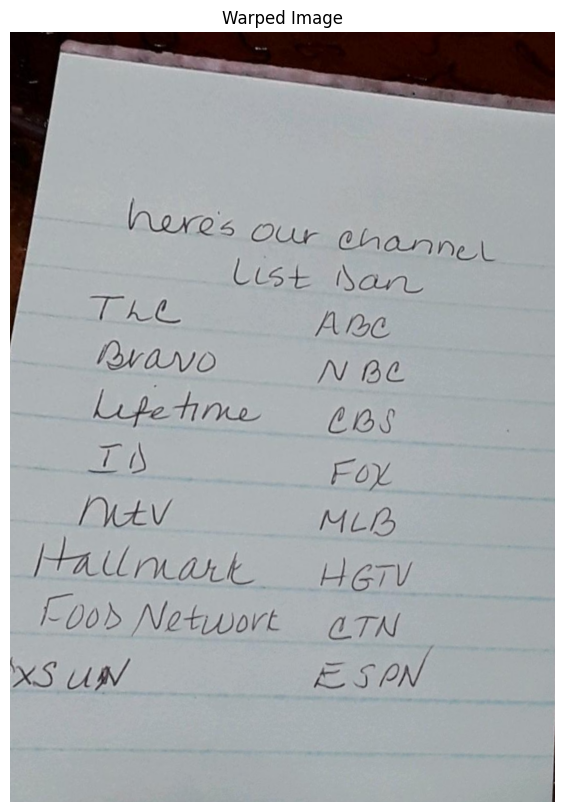

In [ ]:
def compute_homography(src_pts, dst_pts):
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
    return H

def warp_image(image, src_pts, width, height):
    # Points that the document corners will map to
    dst_pts = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)
    H = compute_homography(src_pts, dst_pts)
    warped_image = cv2.warpPerspective(image, H, (width, height))
    return warped_image

def display_image(image, title="Image"):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Assuming document is A4 (210x297mm), convert mm to pixels assuming 300 dpi
width, height = int(8.27 * 300), int(11.69 * 300)  # A4 paper dimensions in pixels
warped_image = warp_image(image, document_corners, width, height)
display_image(warped_image, "Warped Image")


## Step 5: Fully Automated

Detecting document corners...
TOOK method 2


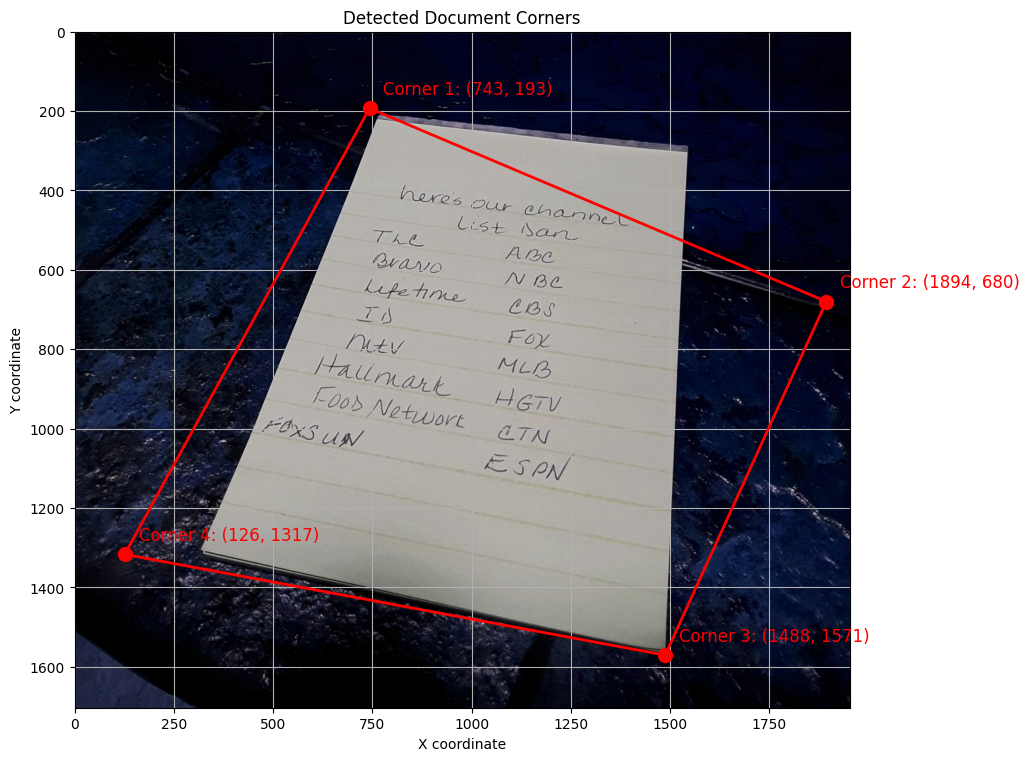

Warping the image...
Enhancing the document...


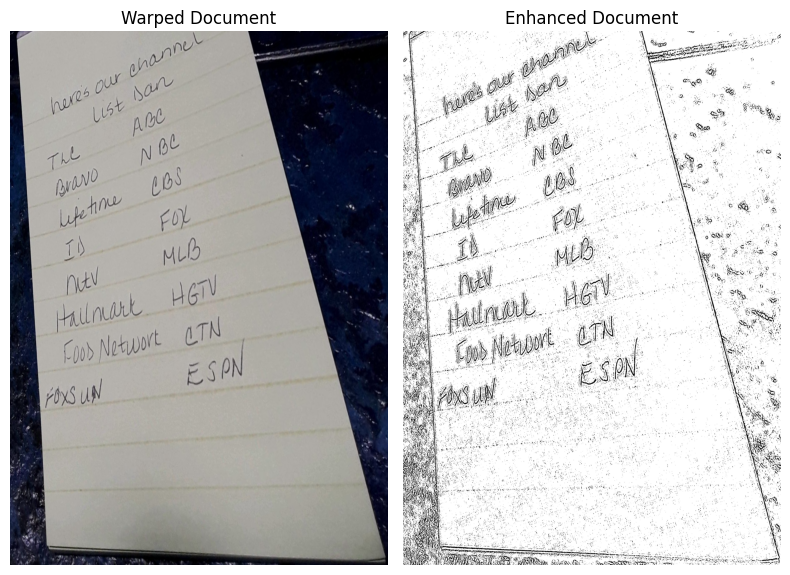

Document corners detected at: [[ 743.  193.]
 [1894.  680.]
 [1488. 1571.]
 [ 126. 1317.]]


In [ ]:
def order_points(pts):
    """
    Order points in clockwise order starting from top-left
    """
    # Initialize a list of coordinates that will be ordered
    rect = np.zeros((4, 2), dtype="float32")

    # The top-left point will have the smallest sum
    # The bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # The top-right will have the smallest difference
    # The bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def find_document_corners_method1(image):
    """
    Find document corners using edge detection and contour analysis
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Edge detection
    edged = cv2.Canny(blur, 75, 200)

    # Dilate to close gaps in edges
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edged, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area (largest first)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Initialize document corners
    document_contour = None

    # Loop through contours to find the document
    for contour in contours[:5]:  # Check only the 5 largest contours
        # Approximate the contour
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

        # If the contour has 4 points, we assume it's the document
        if len(approx) == 4:
            document_contour = approx
            break

    if document_contour is not None:
        # Convert to the correct format and order points
        pts = document_contour.reshape(4, 2)
        return order_points(pts)

    return None

def find_document_corners_method2(image):
    """
    Find document corners using adaptive thresholding and contour analysis
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply bilateral filter to reduce noise while preserving edges
    blurred = cv2.bilateralFilter(gray, 9, 75, 75)

    # Apply adaptive thresholding to get a binary image
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY_INV, 11, 2)

    # Dilate to connect components
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area (largest first)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Initialize document corners
    document_contour = None

    # Loop through contours to find the document
    for contour in contours[:5]:  # Check only the 5 largest contours
        # Approximate the contour
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

        # If the contour has 4 points, we assume it's the document
        if len(approx) == 4:
            document_contour = approx
            break

    if document_contour is not None:
        # Convert to the correct format and order points
        pts = document_contour.reshape(4, 2)
        return order_points(pts)

    return None

def find_document_corners_method3(image):
    """
    Find document corners using morphological operations
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Otsu's thresholding
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Apply morphological operations
    kernel = np.ones((9, 9), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(morph.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area (largest first)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    if contours:
        # Get the largest contour
        largest_contour = contours[0]

        # Find the minimum area rectangle
        rect = cv2.minAreaRect(largest_contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        return order_points(box)

    return None

def auto_detect_document(image):
    """
    Try multiple methods to detect document corners
    """
    # Try the first method
    corners = find_document_corners_method1(image)
    if corners is not None:
        print("TOOK method 1")
        return corners

    # Try the second method if the first fails
    corners = find_document_corners_method2(image)
    if corners is not None:
        print("TOOK method 2")
        return corners

    # Try the third method if the second fails
    corners = find_document_corners_method3(image)
    if corners is not None:
        print("TOOK method 3")
        return corners

    # If all methods fail, use the image corners as a fallback
    height, width = image.shape[:2]
    corners = np.array([
        [0, 0],               # top-left
        [width - 1, 0],       # top-right
        [width - 1, height - 1], # bottom-right
        [0, height - 1]       # bottom-left
    ], dtype=np.float32)

    return corners

def display_image_with_detected_corners(image, corners, title="Document Detection"):
    """
    Displays the image with detected document corners
    """
    # Convert BGR to RGB for matplotlib display
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.title(title)
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.grid(True)

    # Draw corners and lines connecting them
    for i, corner in enumerate(corners):
        x, y = corner
        plt.plot(x, y, 'ro', markersize=10)
        plt.annotate(f'Corner {i+1}: ({int(x)}, {int(y)})',
                    (x, y),
                    textcoords="offset points",
                    xytext=(10, 10),
                    color='red',
                    fontsize=12)

    # Draw lines connecting the corners
    corners_closed = np.vstack([corners, corners[0]])  # Close the shape
    plt.plot(corners_closed[:, 0], corners_closed[:, 1], 'r-', linewidth=2)

    plt.show()

# def compute_homography(src_pts, dst_pts):
#     """
#     Compute the homography matrix
#     """
#     H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
#     return H

# def warp_image(image, src_pts, width, height):
#     """
#     Warp the image using the homography matrix
#     """
#     # Points that the document corners will map to
#     dst_pts = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)

#     # Compute the homography matrix
#     H = compute_homography(src_pts, dst_pts)

#     # Warp the image
#     warped = cv2.warpPerspective(image, H, (width, height))

#     return warped

def enhance_document_image(image):
    """
    Enhance the document image for better readability using OpenCV only
    """
    # Convert to grayscale if not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply adaptive thresholding
    enhanced = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 11, 2)

    return enhanced


def process_document_image(image_url):
    """
    Process a document image: detect corners, warp, and enhance
    """

    # Detect document corners
    print("Detecting document corners...")
    corners = auto_detect_document(image)

    # Display the original image with detected corners
    display_image_with_detected_corners(image, corners, "Detected Document Corners")

    # A4 paper dimensions in pixels (assuming 300 DPI)
    width, height = int(8.27 * 300), int(11.69 * 300)

    # Warp the image
    print("Warping the image...")
    warped = warp_image(image, corners, width, height)

    # Display the warped image
    plt.figure(figsize=(8, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    plt.title("Warped Document")
    plt.axis('off')

    # Enhance the document for better readability
    print("Enhancing the document...")
    enhanced = enhance_document_image(warped)

    # Display the enhanced document
    plt.subplot(1, 2, 2)
    plt.imshow(enhanced, cmap='gray')
    plt.title("Enhanced Document")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return corners, warped, enhanced


# Process the document image
corners, warped_image, enhanced = process_document_image(direct_url)

print(f"Document corners detected at: {corners}")


## Step 5: Save and Download

In [ ]:
cv2.imwrite('warped_image.png', cv2.cvtColor(warped_image, cv2.COLOR_RGB2BGR))  # Save the image
files.download('warped_image.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Report

### Manual Document Corner Selection

How It Works
In the manual approach, the program simply asks the user to type in the coordinates of each
corner of the document. Here’s the general flow:
- Read and display image from URL.
- You’re prompted to enter the (x,y)(x,y) coordinates for each corner.
- The manually_select_corners() function collects those coordinates.
- We calculate a homography transformation based on these points (used OpenCV).
- The image is warped so that the document appears flat and front-facing (used OpenCV).
- You can also save and download the image. To download manual warped image, skip
automatic implementation

Reasons for Manual Approach
- Reliability: A person can accurately spot corners even if the image is poorly lit or has a
busy background.
- Precision: If needed, users can zoom in and pick exact pixels.
- Flexibility: Works for any kind of document, regardless of shape or color.
- Simplicity: No heavy computer vision algorithms are needed.
- Debug/Verification: It can serve as a reference or “ground truth” when testing
automated methods.

Limitations
- Time-consuming: You have to do it by hand for each document.
- Not scalable: Impractical when dealing with many documents.
- Subjective: Different people might click slightly different spots.
- Requires user know-how: The user must understand what “corners” actually mean in
the image.

### Automatic Document Corner Detection
How It Works

Our automatic approach uses computer vision techniques to find corners on its own:
- Preprocess the image (convert to grayscale, blur it, detect edges).
- Look for contours that could outline the document.
- Approximate those contours to identify corner points.
- Use fallback methods if the main technique fails.
- Order the corners properly so we can apply the homography transformation.

Reasons for Automatic Approach
- Efficiency: No human interaction needed for each document.
- Scalability: Can handle large batches of documents quickly.
- Consistency: Uses the same algorithmic rules every time.
- Speed: Faster than manually picking corners for each image.
- Easy Integration: Can be part of a bigger document-processing pipeline.

Implementation Details

We rely on OpenCV for most image processing tasks. Here’s a quick breakdown of our
functions:

- Read and display image from URL.
- Then skip manual implementation
- The automatic implementation will do the following:
 - auto_detect_document(): Main function that attempts multiple detection
strategies in sequence.
 - find_document_corners_method1(), find_document_corners_method2(), f
ind_document_corners_method3(): Three different corner-detection methods.
 - order_points(): Makes sure we label corners consistently (top-left, top-right,
etc.).
 - compute_homography() and warp_image(): Handle perspective transformation.
 - enhance_document_image(): Improves readability of the final warped image.

- Then will display and print necessary information
- Last step will be to save warped image and download

Limitations
- Accuracy Issues: Complex backgrounds or poor lighting can confuse the algorithm.
- Parameter Sensitivity: You often have to tune thresholds or other parameters.
- Complexity: Requires some understanding of computer vision concepts.
- Computational Cost: More resource-heavy compared to the manual approach.

Additional Notes

- Testing: We tried both methods on a few sample images with different lighting and
backgrounds. The manual method was always accurate (though slow), while the
automatic method was faster but sometimes needed parameter tweaks, overall, very
unreliable.
- Possible Improvements: Using more advanced techniques (like machine learning or
Hough transforms for line detection) could make the automatic method more robust.
Overall, we compared a manual corner selection approach—simple but time-intensive—to
an automatic approach that scales well but can fail on tricky images